# Comparing the high-resolution bayesian normative model for cortical thickness using a CSS spectral kernel with a direct model (PYMC with ADVI)

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [5]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [7]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(lrxyz.min(0) + lrxyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(lrx.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(lrx.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


## Load aggregated data

---

In [8]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0).reset_index(drop=True)
demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0


## Load high-resolution thickness data

---

In [9]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');


## Load the CSS kernel

---

In [10]:
# load the stored kernel
fwhm = 5
css_kernel_eigenvalues = load_np(f'{main_dir}/data/npy/css_kernel_eigenvalues_{fwhm}mmFWHM.npy');
css_kernel_eigenvectors = load_np(f'{main_dir}/data/npy/css_kernel_eigenvectors_{fwhm}mmFWHM.npy');


## Encode the high-resolution data by kernel and attach to the demography data

---

In [11]:
# center the data prior to encoding
all_thickness_data_encoded = np.dot(all_thickness_data, css_kernel_eigenvectors)
all_thickness_data_encoded.shape


(2473, 2001)

In [12]:
demography_extended_df = pd.concat(
    [
        demography_df,
        pd.DataFrame(
            all_thickness_data_encoded,
            columns=[f'thickness_css_{i}' for i in range(all_thickness_data_encoded.shape[1])],
        ),
    ],
    axis=1,
)

demography_extended_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode,thickness_css_0,thickness_css_1,thickness_css_2,...,thickness_css_1991,thickness_css_1992,thickness_css_1993,thickness_css_1994,thickness_css_1995,thickness_css_1996,thickness_css_1997,thickness_css_1998,thickness_css_1999,thickness_css_2000
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0,540.848068,328.405088,-58.875203,...,-2.989428,-0.068005,3.195871,-0.486385,1.388692,0.790643,-1.385377,-0.132055,0.294909,1.125785
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0,543.507714,323.441478,-50.223979,...,-2.861579,0.173527,0.470815,0.335621,1.752842,-1.659001,-0.929015,-1.196669,0.499736,-0.200770
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0,557.540900,334.750308,-47.242142,...,-1.953069,1.547393,1.052983,-0.282225,-0.662044,-0.657760,-1.773588,-1.853987,-0.479072,-1.234758
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0,541.266533,324.140321,-55.719439,...,-0.562489,0.933322,0.347921,1.346396,-1.391554,-0.904728,-0.204043,0.522450,-0.127720,1.778896
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0,568.037553,342.473082,-61.126235,...,-0.157777,1.118155,0.281123,-0.601192,0.991797,-0.982564,-0.976174,1.511172,-0.405743,0.693013


## Load fitted models of normative distributions for every kernel

---

In [13]:
%%time
# load the stored posterior means
kernel_posterior_means = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_css_kernel_posterior_means_pymc_advi.nc')


CPU times: user 21.4 ms, sys: 6.75 ms, total: 28.2 ms
Wall time: 26.5 ms


In [14]:
# Estimate covariance matrix
covariances = np.cov(all_thickness_data_encoded.T)
correlations = np.corrcoef(all_thickness_data_encoded.T)
covariances.shape


(2001, 2001)

In [15]:
# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

## General function to directly compute the normative model for a feature

---

In [26]:
def run_pymc_advi_for_feature(input_df, feature_name):
    # sample from required columns
    sample_df = input_df[['age', 'site', 'sex', feature_name]].copy()

    # Data preperation
    age = sample_df['age'].values
    age_standardized = (age - age.mean()) / age.std()
    thickness = sample_df[feature_name].values
    thickness_standardized = (thickness - thickness.mean()) / thickness.std()
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
    # Splines to model nonlinear age effects on thickness
    # number of spline nuts (could be tuned)
    num_knots = 3
    knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
    # create b spline basis for regression using patsy
    B_spline_age = patsy.dmatrix(
        "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
        {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
    )

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs)),
    }

    feature_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
    # models_dict[kernel_name] = advi_model

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with feature_advi_model:
        # minibatch variables
        age_standardized_t = pm.Minibatch(age_standardized, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs, 512)
        site_idx_t = pm.Minibatch(site_idxs, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        thickness_standardized_t = pm.Minibatch(thickness_standardized, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
        sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
        sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

        # Priors    
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")

        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

        # age splines
        w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")

        # Estimated thickness
        thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

        # Model error
        # nonlinear age error
        w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")

        # constant sex error
        error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")

        # random site error
        error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

        # Error estimate
        thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))

        # Skewness estimate
        # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
        # for sake of simplicity let's not model skewness

        # Likelihood (sampling distribution) of observations
        # need to figure out how to bound the distribution
        # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
        # thickness_like = pm.SkewNormal(
        thickness_like = pm.Normal(
            "thickness_like",
            mu=thickness_est,
            sigma=thickness_error,
            observed=thickness_standardized_t,
            total_size=len(sample_df),
        )
            # alpha=thickness_skewness,
    
        # run ADVI with minibatch
        feature_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

        # sample from trace
        feature_advi_model_idata = pm.sample_prior_predictive()
        feature_advi_model_idata.extend(feature_approx.sample(2000))
        pm.sample_posterior_predictive(feature_advi_model_idata, extend_inferencedata=True)
        # idata_dict[kernel_name] = advi_model_idata
    
    # stored_model_file = f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc'
    # kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
    # return (kernel_name, stored_model_file)
    return (feature_name, feature_advi_model, feature_advi_model_idata)
    

## Modelling mean thickness 🧠

---


### Define query: mean thickness 🧠

---


In [18]:
# mean thickness vector representation
mean_thickness_vector = np.ones(css_kernel_eigenvectors.shape[0]) / css_kernel_eigenvectors.shape[0]
mean_thickness_vector_encoded = np.dot(mean_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


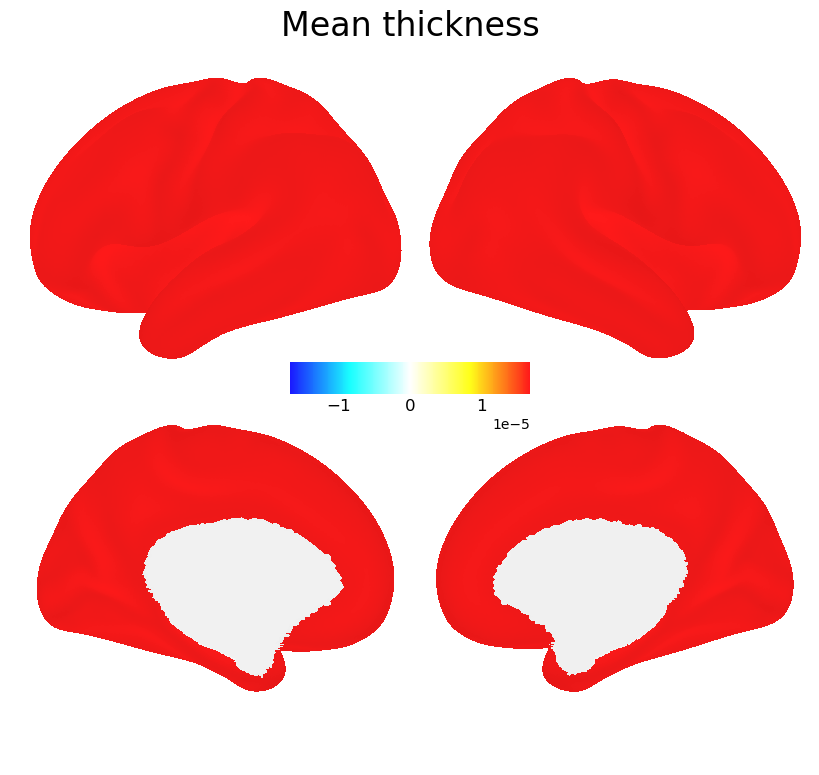

In [32]:
plot_data_on_brain_surface(
    mean_thickness_vector,
    title=f"Mean thickness",
    symmetric_cbar=True,
)


### Modelling mean thickness 🧠 directly without any kernels

---


In [27]:
demography_df['mean_thickness'] = mean_thickness_vector.dot(all_thickness_data.T)
# demography_df['mean_thickness'] = np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)

feature_name, feature_advi_model, feature_advi_model_idata = run_pymc_advi_for_feature(demography_df, 'mean_thickness')
feature_posteriors = feature_advi_model_idata.posterior
feature_posterior_means = feature_posteriors.mean(dim=["chain", "draw"])


Finished [100%]: Average Loss = 286.86
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [38]:
features = {}

features[feature_name] = {'model': feature_advi_model, 'idata': feature_advi_model_idata, 'query': mean_thickness_vector, 'encoded_query': mean_thickness_vector_encoded}


CPU times: user 298 ms, sys: 116 ms, total: 413 ms
Wall time: 170 ms


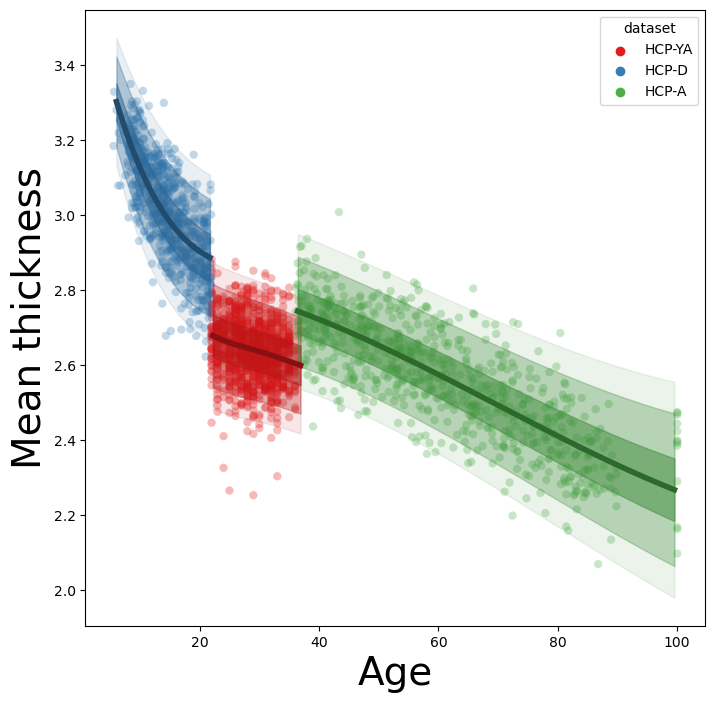

In [28]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(
    data=demography_df,
    x='age',
    y=feature_name,
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    feature_y_ppc_mu_mean = (
        feature_posterior_means['intercept_sex'].isel(sex=0) +
        feature_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_age']
        )
    ) * demography_df[feature_name].std() + demography_df[feature_name].mean()
    y_ppc_mu_mean = feature_y_ppc_mu_mean

    feature_y_ppc_sigma_mean = (
        feature_posterior_means['error_sex'].isel(sex=0) +
        feature_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_error_age']
        )
    ) * demography_df[feature_name].std()
    y_ppc_sigma_mean = feature_y_ppc_sigma_mean

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


### Modelling mean thickness 🧠 indirectly with kernels

---


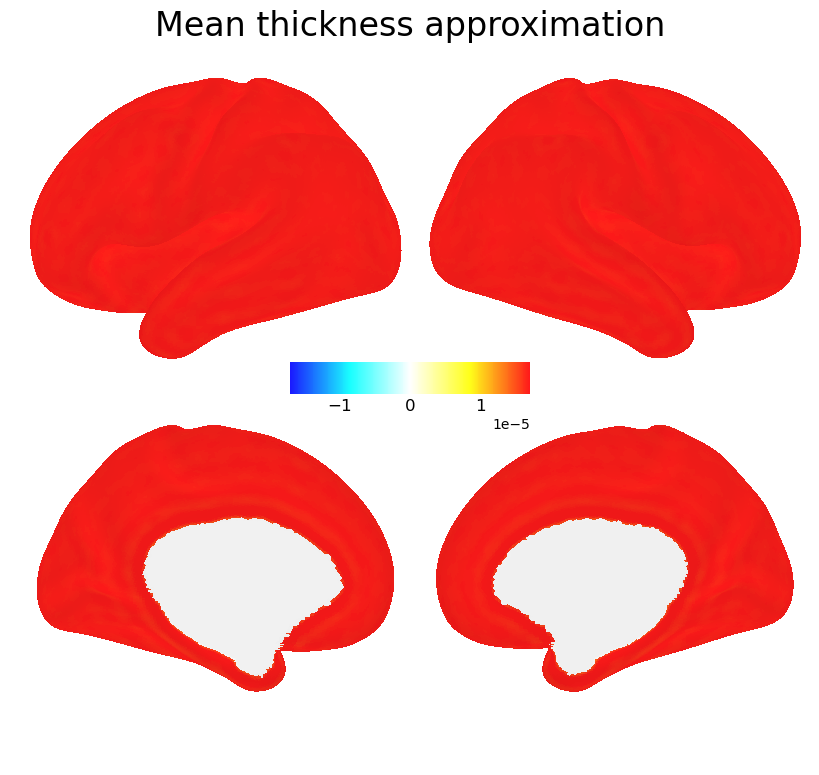

In [20]:
plot_data_on_brain_surface(
    np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation",
    symmetric_cbar=True,
)


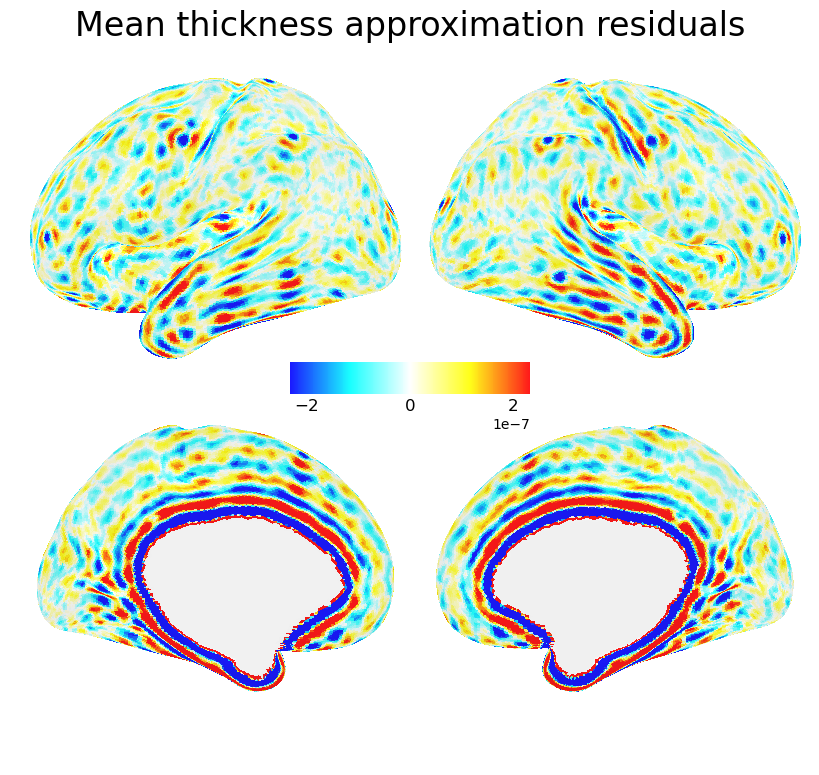

In [21]:
plot_data_on_brain_surface(
    mean_thickness_vector - np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation residuals",
    symmetric_cbar=True,
)


CPU times: user 15.3 s, sys: 10 s, total: 25.3 s
Wall time: 1.72 s


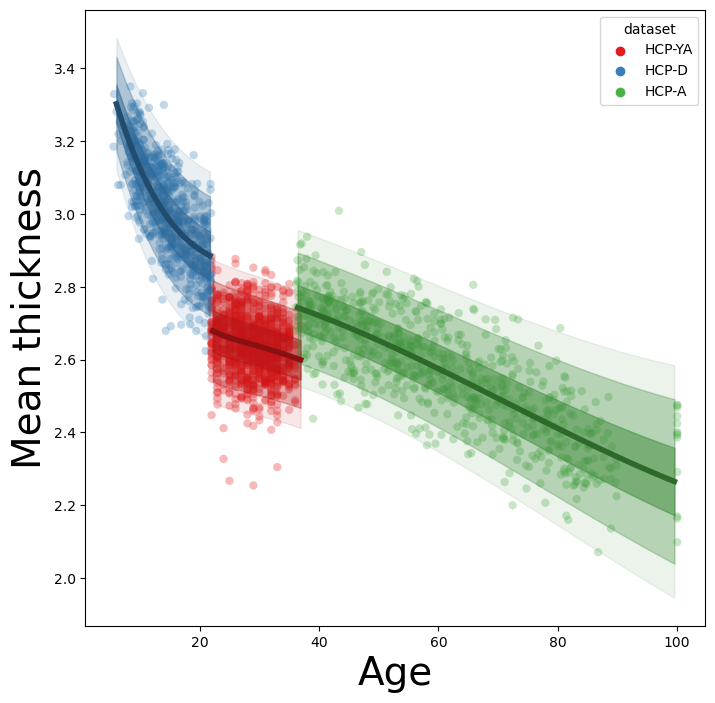

In [23]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        mean_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


CPU times: user 16.4 s, sys: 11.5 s, total: 27.9 s
Wall time: 1.85 s


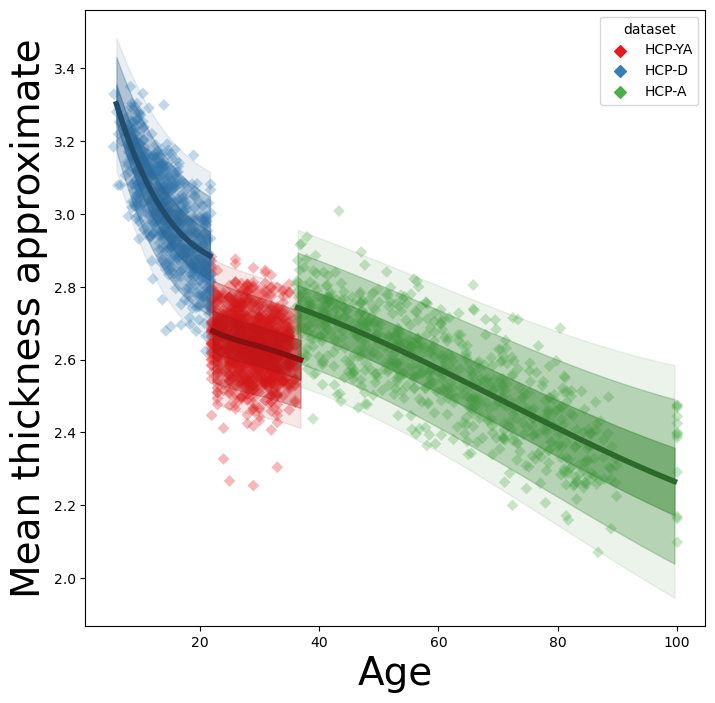

In [25]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

demography_df['query_thickness'] = np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
    markers=['D', 'D', 'D'],
    style='dataset',
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness approximate', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        mean_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


## Modelling arbitrary queries: thickness of an atlas region 🎯

---


### Define query: thickness of an atlas region 🎯

---


In [29]:
from sklearn.preprocessing import normalize

In [30]:
# load the glasser atlas
atlas_file = f'{main_dir}/data/templates/hcp_parcel/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
atlas = nib.load(atlas_file)


In [31]:
# mean thickness vector representation
region_idx = 8
query_thickness_vector = normalize((atlas.get_fdata()==region_idx).astype(float).reshape(1,-1), norm='l1')[0]
query_thickness_vector_encoded = np.dot(query_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


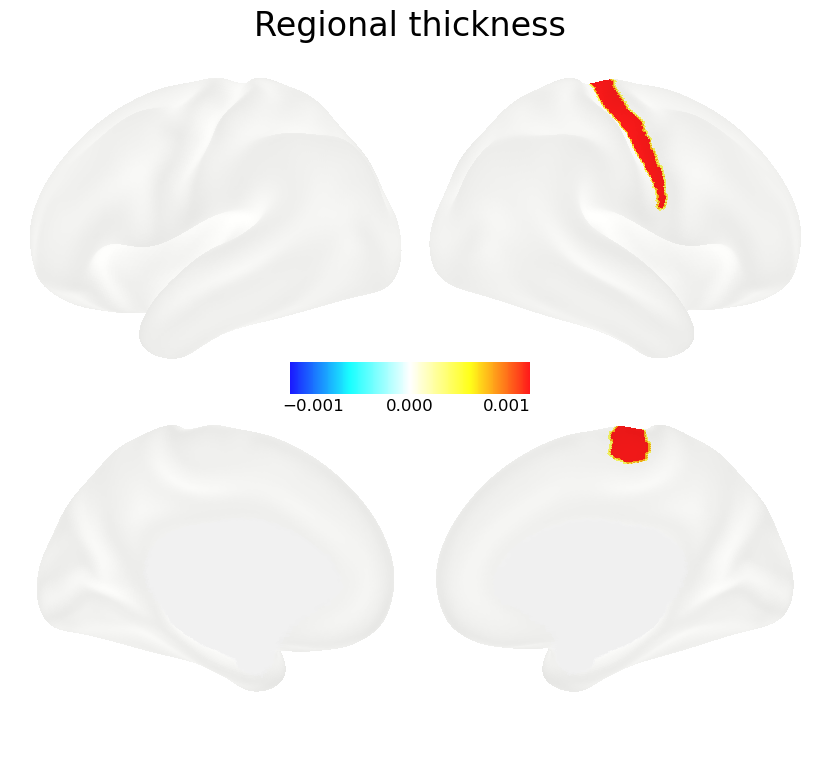

In [34]:
plot_data_on_brain_surface(
    query_thickness_vector,
    title=f"Regional thickness",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


### Modelling arbitrary queries: thickness of an atlas region 🎯 directly without any kernels

---


In [ ]:
demography_df['query_thickness'] = query_thickness_vector.dot(all_thickness_data.T)
# demography_df['mean_thickness'] = np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)

feature_name, feature_advi_model, feature_advi_model_idata = run_pymc_advi_for_feature(demography_df, 'query_thickness')


In [43]:
features[feature_name] = {'model': feature_advi_model, 'idata': feature_advi_model_idata, 'query': query_thickness_vector, 'encoded_query': query_thickness_vector_encoded}

feature_posteriors = features[feature_name]['idata'].posterior
feature_posterior_means = feature_posteriors.mean(dim=["chain", "draw"])


CPU times: user 314 ms, sys: 79.4 ms, total: 394 ms
Wall time: 155 ms


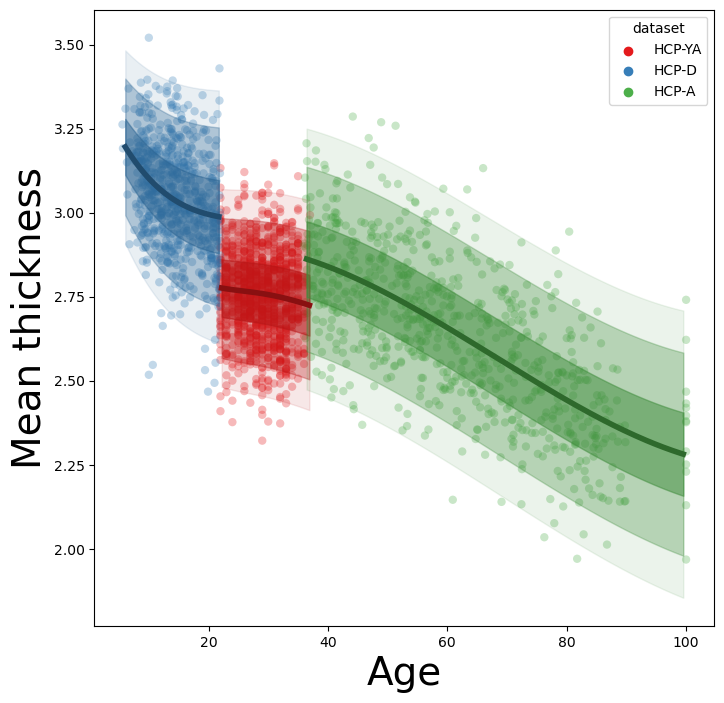

In [42]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(
    data=demography_df,
    x='age',
    y=feature_name,
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    feature_y_ppc_mu_mean = (
        feature_posterior_means['intercept_sex'].isel(sex=0) +
        feature_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_age']
        )
    ) * demography_df[feature_name].std() + demography_df[feature_name].mean()
    y_ppc_mu_mean = feature_y_ppc_mu_mean

    feature_y_ppc_sigma_mean = (
        feature_posterior_means['error_sex'].isel(sex=0) +
        feature_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_error_age']
        )
    ) * demography_df[feature_name].std()
    y_ppc_sigma_mean = feature_y_ppc_sigma_mean

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


### Modelling arbitrary queries: thickness of an atlas region 🎯 indirectly with kernels

---


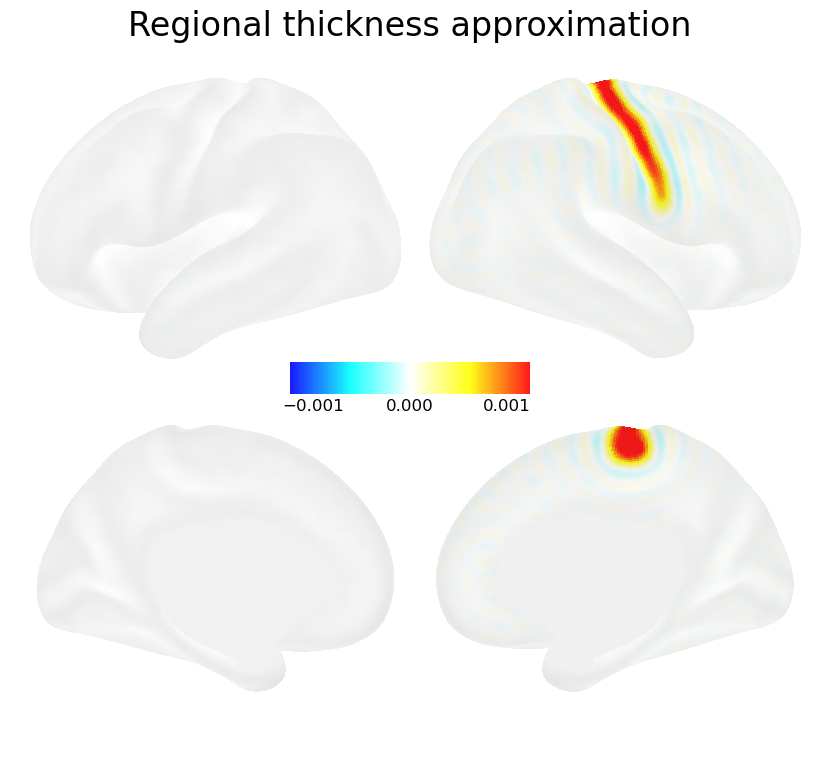

In [36]:
plot_data_on_brain_surface(
    np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Regional thickness approximation",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


In [53]:
css_kernel_eigenvectors.shape

(59412, 2001)

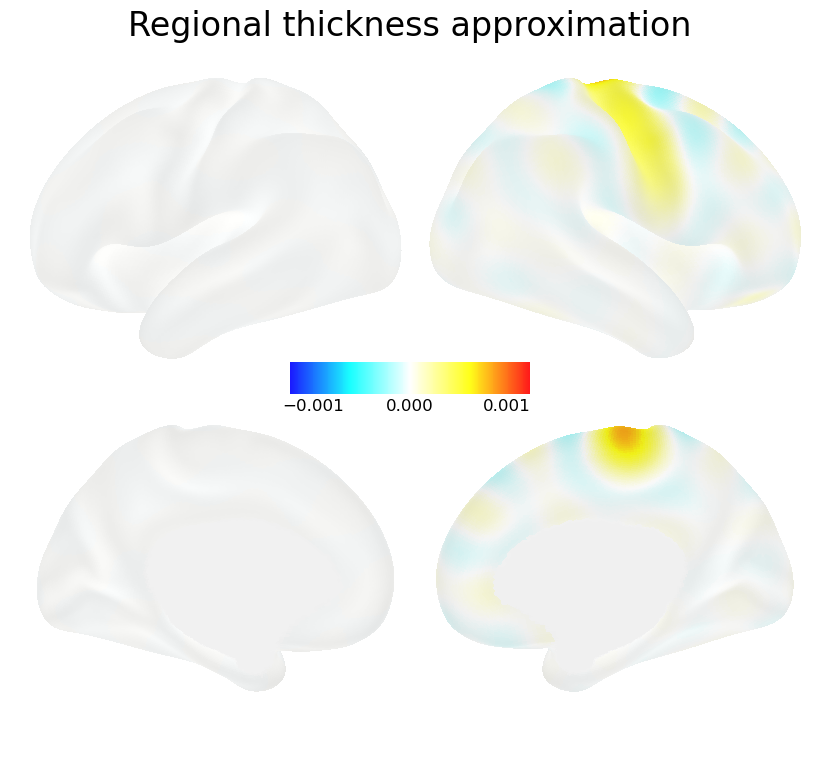

In [56]:
plot_data_on_brain_surface(
    np.dot(query_thickness_vector_encoded[:,:200], css_kernel_eigenvectors.T[:200])[0],
    title=f"Regional thickness approximation",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


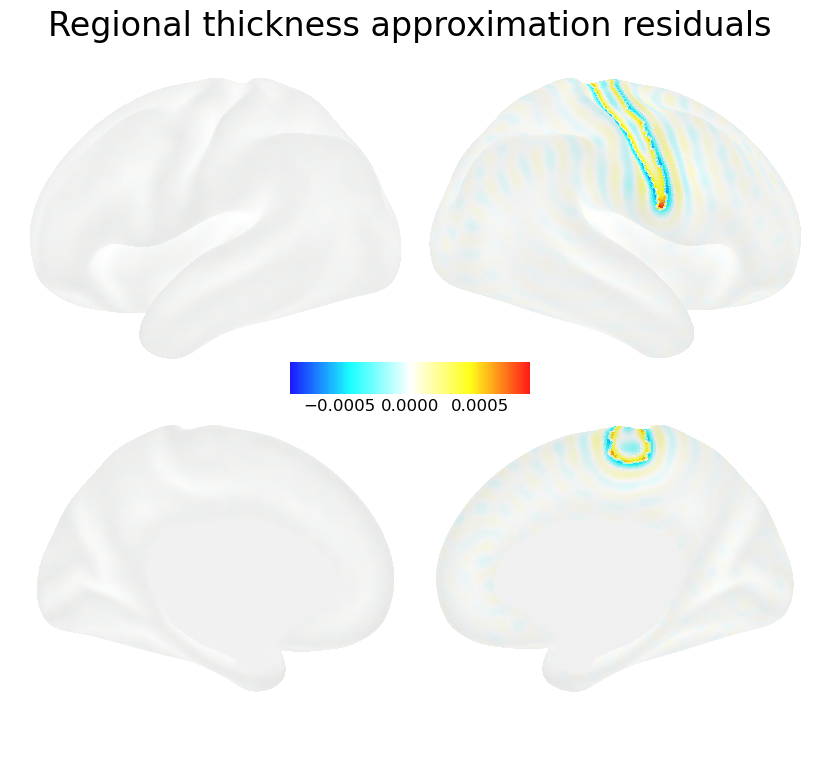

In [37]:
plot_data_on_brain_surface(
    query_thickness_vector - np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Regional thickness approximation residuals",
    symmetric_cbar=True, vmin=0, vmax=(query_thickness_vector - np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0]).max(),
)


CPU times: user 16.2 s, sys: 11.4 s, total: 27.6 s
Wall time: 1.88 s


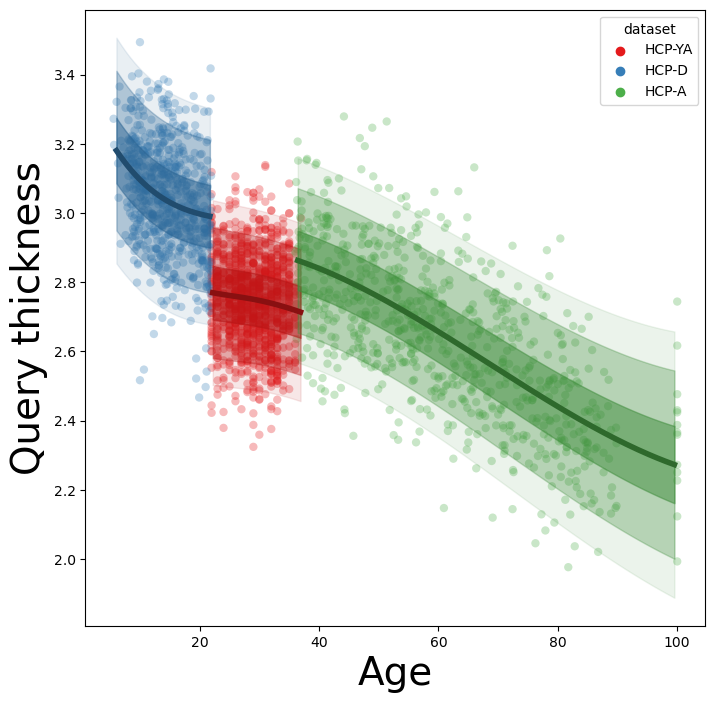

In [47]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(
    data=demography_df,
    x='age',
    y=feature_name,
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Query thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(features[feature_name]['encoded_query'].reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    features[feature_name]['encoded_query'].reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        features[feature_name]['encoded_query'].reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


CPU times: user 16.8 s, sys: 11.3 s, total: 28.1 s
Wall time: 1.82 s


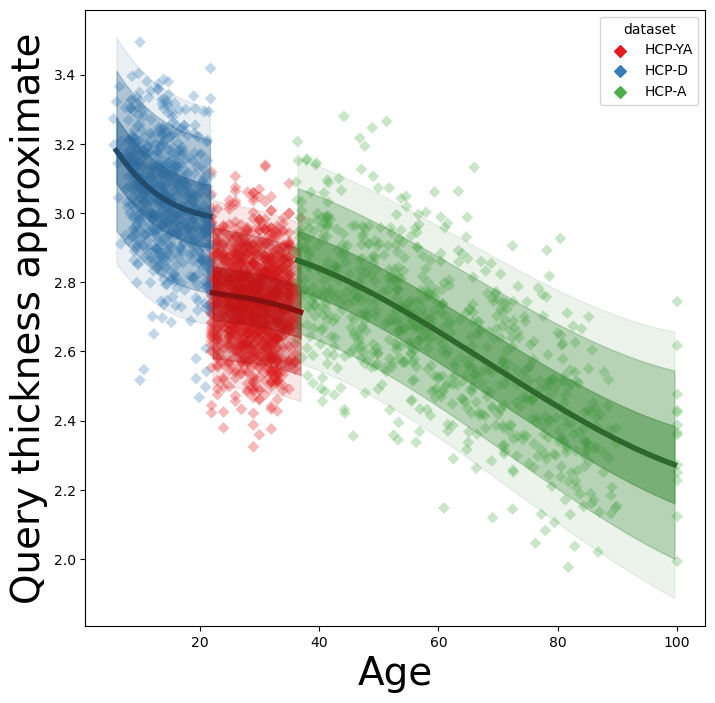

In [49]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

demography_df['query_thickness'] = np.dot(features[feature_name]['encoded_query'], css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
    markers=['D', 'D', 'D'],
    style='dataset',
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Query thickness approximate', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(features[feature_name]['encoded_query'].reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    features[feature_name]['encoded_query'].reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        features[feature_name]['encoded_query'].reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


What if a direct model wanted to assess the approximated query?

### Modelling arbitrary queries: thickness of an atlas region 🎯 directly, but with kernels

---


In [50]:
demography_df['approximate_query_thickness'] = np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)
# demography_df['mean_thickness'] = np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0].dot(all_thickness_data.T)

feature_name, feature_advi_model, feature_advi_model_idata = run_pymc_advi_for_feature(demography_df, 'approximate_query_thickness')


Finished [100%]: Average Loss = 512.86
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [51]:
features[feature_name] = {'model': feature_advi_model, 'idata': feature_advi_model_idata, 'query': np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0], 'encoded_query': query_thickness_vector_encoded}

feature_posteriors = features[feature_name]['idata'].posterior
feature_posterior_means = feature_posteriors.mean(dim=["chain", "draw"])


CPU times: user 284 ms, sys: 124 ms, total: 408 ms
Wall time: 159 ms


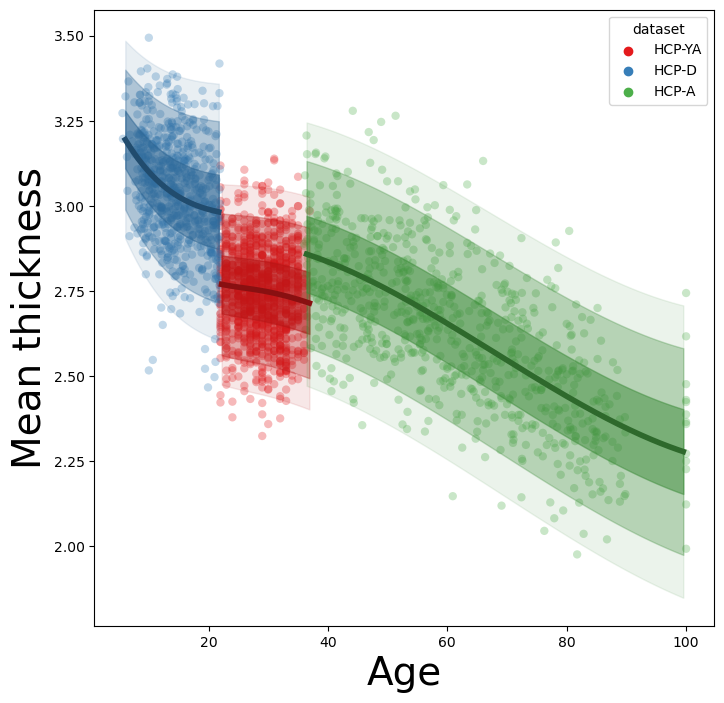

In [52]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(
    data=demography_df,
    x='age',
    y=feature_name,
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    feature_y_ppc_mu_mean = (
        feature_posterior_means['intercept_sex'].isel(sex=0) +
        feature_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_age']
        )
    ) * demography_df[feature_name].std() + demography_df[feature_name].mean()
    y_ppc_mu_mean = feature_y_ppc_mu_mean

    feature_y_ppc_sigma_mean = (
        feature_posterior_means['error_sex'].isel(sex=0) +
        feature_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            feature_posterior_means['w_error_age']
        )
    ) * demography_df[feature_name].std()
    y_ppc_sigma_mean = feature_y_ppc_sigma_mean

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )
